# Practical 1: Dimensionality Reduction

**Course:** WBCS032-05 Introduction to Machine Learning  
**Student Names:**

Avery Kozák (s5559294) & Rik de Hoop (s5303893)

---

## Assignment Overview

In this assignment, you will implement Principal Component Analysis (PCA) to reduce the dimensionality of the data, as discussed in the lecture.

You will work with the `COIL20.mat` dataset on Themis. The dataset consists of 1440 images, where each image has a size of $32 \times 32$ pixels and is flattened into a vector of length 1024. All images are stored in one matrix of size $1440 \times 1024$, where each row represents one image and each column corresponds to a pixel. The images come from 20 different objects, and each object is recorded at 72 different rotation angles, with a rotation step of 5 degrees.

## 1. Introduction (1 point)

Describe the goal of this assignment and briefly explain why dimensionality reduction and PCA are useful in data analysis.

**Your answer here:**

Our goal, in practical terms, is to reduce the dimensionality of our dataset - from 1024 (i.e. the number of pixels per image) to a lower value. This means transforming our dataset in such a way that the resulting dataset has a lower number of dimensions (i.e. its vectors have fewer components) while retaining the maximal amount of information.

One reason dimensionality reduction like this is useful is because decreasing the number of dimensions in a dataset makes it significantly less computationally expensive to analyse the data (by virtue of there being less information to process, i.e. less time and space)

Additionally, a high number of dimensions may cause statistical methods to fail - the more dimensions, the harder it is to narrow data points down to similar "regions", or to ascertain patterns or correlations between data points. This referred to as the "curse of dimensionality".

When applied properly, dimensionality reduction can therefore allow for more efficient estimations without compromising precision. This has broad applications in data analysis both within and beyond machine learning.

PCA is a linear method for feature extraction, which is a type of dimensionality reduction. Feature extraction works by embedding, mapping, a higher-dimensional space (i.e. the original dataset) to a lower-dimensional space (i.e. the reduced dataset).

PCA is useful because it can capture the most statistically significant "components" (i.e. linear combinations of dimensions) of the original dataset and reduce it to only these.

## 2. Methods (3 points)

### 2.1 Explain the PCA Algorithm (0.5 points)

Explain the PCA algorithm in a general manner.

**Your answer here:**

PCA embeds the original dataset by constructing a "best-possible linear approximation function" of sorts.

Namely, PCA constructs a $\mathbb{R}^n \to \mathbb{R}^d$ linear function (a *projection* to lower-dimensional space) in the form of a $d \times n$ matrix, where $d$ is the desired target dimensionality. It chooses this linear function so as to both minimise information loss and maximise (retained) variance.

To do this, we first normalise our dataset. Then, we construct the covariance matrix of the normalised data. (Note that variance is a function of this covariance matrix.)

We seek our transformation matrix to have rows - vectors - such that we retain the maximum variance. (We also fix them to be unit vectors to avoid arbitrarily scaling our variance higher/lower.)

By writing the maximisation of the variance as a Lagrange multiplier and differentiating, we find that any such vector maximises variance if it is an eigenvector of the covariance matrix.

We call these eigenvectors the *principal components* of our dataset, and since the covariance is symmetrical, we have one eigenpair for each dataset dimension. 

The magnitude of each eigenvector's eigenvalue is proportional to how much of the variance is captured by that principal component - i.e. that linear combination of the original dataset variables.
Hence, we call the eigenvector of the $n$-th largest eigenvalue the $n$-th principal component.

Therefore, by taking the first $d$ principal components for the rows of our transformation matrix, we create a transformation that will extract $d$ (new) dimensions as linear combinations of the original ones, with each constructed so as to capture as much of the original variance as possible.

### 2.2 Implementation (2.5 points)

You need to implement the PCA algorithm **yourself**. Both the code quality and correctness will be graded.

*__Note:__* **Do not change the cell labels! Themis will use them to automatically grade your submission.**

In [89]:
# Load required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.manifold import TSNE

# Data configuration
data_file_path = 'COIL20.mat'
image_shape = (32, 32)

# PCA parameters
d = 40  # Target dimensionality

# t-SNE parameters
tsne_perplexity = 4

#### PCA Algorithm Steps

Implement the following steps:

1. **Normalize the data:**
   $$Z = \frac{X - \mu}{\sigma}$$
   where $\mu$ is the mean of all samples and $\sigma$ is the standard deviation.

2. **Compute the covariance matrix of the normalized data** and obtain its eigenvalues $D$ and eigenvectors $U$.  
   You may use `np.linalg.eig` in Python.

3. **Sort the eigenvectors in descending order of their eigenvalues** and select the first $d$ principal components to form $U_d$.

4. **Reduce the dimensionality of the data** by projecting the normalized data onto the selected principal components.

In [90]:
# Implement PCA here
def PCA(x, d):
    """
    Apply Principal Component Analysis.

    Args:
        x (np.ndarray): Dataset matrix (each column represents a variable)
        d (int): Dimensionality of the projection

    Returns:
        tuple: (U_d, eigen_values, Z_d)
            - U_d (np.ndarray): Matrix of principal components, sorted descending
            - eigen_values (np.ndarray): Eigenvalues, sorted descending
            - Z_d (np.ndarray): Reduced version of the dataset
    """
    
    # 1. normalize the data
    mean = np.mean(x, axis=0)
    sd = np.std(x, axis=0)
    norm_x = (x-mean) / sd

    # 2. calculate cov. matrix, obtain its D, U (=> cv_eval, cv_evec)
    covmat = np.cov(norm_x, rowvar=False)
    (cv_eval, cv_evec) = np.linalg.eig(covmat)

    # 3. sort these in descending order
    # (linalg.eig returns eigenvectors in wrong orientation! transposing fixes this.)
    eigen = sorted(list(zip(cv_eval, cv_evec.transpose())), key=lambda tup:tup[0], reverse=True)
    (eigvals, eigvecs) = zip(*eigen)
    
    # 4. select first d columns of eigenvector matrix.
    # turn this into a matrix, apply to our normalised values => reduced dataset
    first_d_principals = np.array(eigvecs[0:d])
    umat = np.array(first_d_principals)
    reduced = np.matvec(umat, norm_x)

    # return *all* principal components and eigenvalues, but *only* the reduced (transformed) dataset (given param. d)
    # (output expects this matrix transposed)
    return (umat.transpose(), np.array(eigvals), reduced)

In [91]:
# Extract dataset
# (Images are stored in matrix under "X")
dataset = scipy.io.loadmat(data_file_path)["X"]

In [92]:
# Apply PCA to the dataset
U_d, eigen_values, Z_d = PCA(dataset, d)

## 3. Experimental Results (4 points)

*__Note:__* This section is not graded by Themis.

### 3.1 Eigenvalue Profile

Write code in the cell below to plot the eigenvalue profile of the data. This plot helps determine how many principal components to retain for dimensionality reduction. Make sure that all plots are clearly labeled. Each figure must include labeled axes, an appropriate title, and a legend where applicable.

- **X-axis:** Eigenvalue indices $(1, 2, \ldots, 1024)$
- **Y-axis:** Eigenvalue magnitude

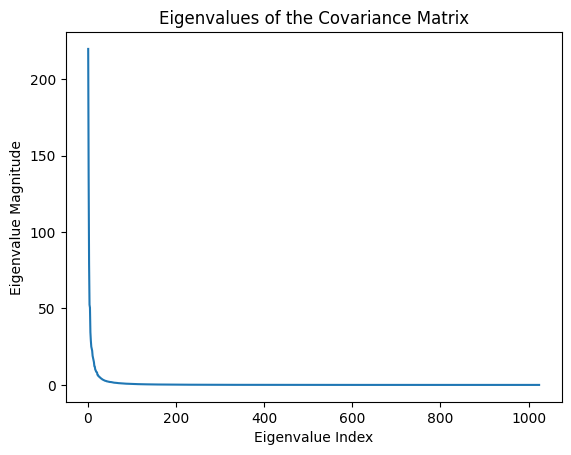

In [93]:
# Eigenvalue indices
indices = np.arange(1, len(eigen_values) + 1)
plt.plot(indices, eigen_values)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Eigenvalues of the Covariance Matrix")

plt.show()

### 3.2 Dimensionality Table

Create a table reporting the dimensionality $d$ required to keep 0.9, 0.95, and 0.98 fraction of the total variance. Write code in the cell below to compute these values, then fill in the table.

Use the formula:
$$d = \frac{\sum_{i=1}^{d}\lambda_i}{\sum_{i=1}^{n}\lambda_i}$$

In [100]:
eigen_values = np.array(eigen_values)
total_variance = np.sum(eigen_values)

# Cumulative explained variance ratio
cum_var_ratio = np.cumsum(eigen_values) / total_variance

# index trick, converts array to boolean array, then uses numpy argmax to find the first where the condition is true
d_90 = np.argmax(cum_var_ratio >= 0.90) + 1
d_95 = np.argmax(cum_var_ratio >= 0.95) + 1
d_98 = np.argmax(cum_var_ratio >= 0.98) + 1

print(f"d_90={d_90}, d_95={d_95}, d_98={d_98}")


d_90=55, d_95=107, d_98=206


| Variance Fraction | Dimensionality (d) |
|-------------------|-------------------|
| 0.90              | 55                |
| 0.95              | 107               |
| 0.98              | 206               |

### 3.3 t-SNE Visualization

Visualize the reduced data using t-SNE in a 2-dimensional feature space.

- Use different colors for data points from different objects
- Every 72 data examples correspond to one object
- You can use `sklearn.manifold.TSNE` in Python with the configured perplexity parameter

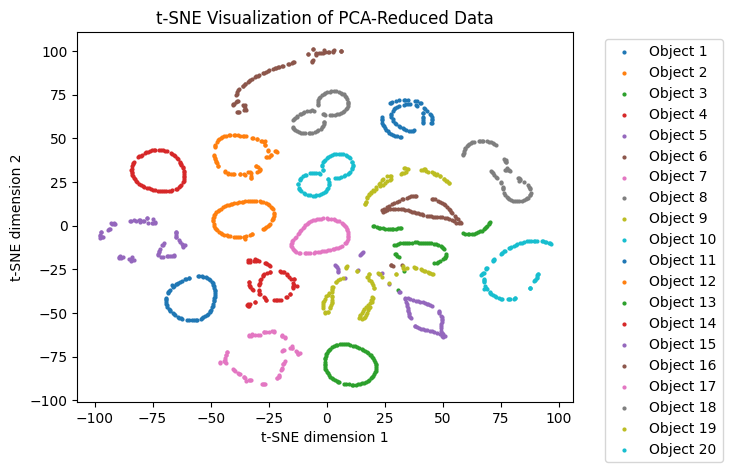

In [102]:
num_objects = 20
samples_per_object = 72

labels = np.repeat(np.arange(num_objects), samples_per_object)

Z_tsne = TSNE(n_components=2, perplexity=tsne_perplexity).fit_transform(Z_d)

for obj in range(num_objects):
    idx = labels == obj
    plt.scatter(Z_tsne[idx, 0], Z_tsne[idx, 1], label=f"Object {obj + 1}", s=4)

plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE Visualization of PCA-Reduced Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## 4. Discussion (2 points)

Discuss your observations on the obtained results:
- What does the eigenvalue profile tell you about the data?
- How well does PCA reduce the dimensionality while preserving variance?
- What do you observe in the t-SNE visualization? Are the objects well-separated?

**Your answer here:**

- The eigenvalue associated with a variable shows how much information is preserved when using the variable. In the case of this data, the values sharply drop after about 50 dimensions, making the variables less relevant.
- Applying PCA onto the data set appears to be very effective; it can preserve as much as 98% of the variance while reducing dimensionality by about 80% (from 1024 to just 206). Up to 90% of variance can be preserved while reducing dimensionality by 95% (to a mere 55 dimensions).
- Most objects are well-separated; that is, points belonging to the same object are closer together, and those from different objects are further apart. One can reasonably separate data points into regions that correspond to the object the data points belong to.
    - Only a few objects appear to be difficult to separate (the two notable cases being seen at t-SNE dimensions of about 25 and -50, in dark yellow and purple).

### A note on Themis
Themis will only grade your implementation of the PCA algorithm, thus giving a maxiumum of `2.5` points. It does so by executing every cell up to and including the PCA call. Make sure your code runs without errors and produces the expected outputs before submitting.

## Contribution

State your individual contribution.

**Your answer here:**

Rik: 3 and part of 4

Avery: 1, 2, and part of 4